<a href="https://colab.research.google.com/github/arunasrivastava/AttentionGate/blob/main/Another_copy_of_TIMIT_Finetune_Ginic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎤 Speech-to-Phoneme Model Finetuning! 🪄


Hey there! This notebook helps you finetune a model on the TIMIT dataset
to convert speech into IPA phonemes (those tiny sound units that make up words).

What's a phoneme? It's like the DNA of speech! For example:
- "cat" = /k/ + /æ/ + /t/
- "dog" = /d/ + /ɔ/ + /g/
- "fish" = /f/ + /ɪ/ + /ʃ/

Let's make some speech recognition happen! 🎯

## Basic Setup

In [ ]:
%cd /content/
!git clone https://github.com/KoelLabs/ML.git

/content
Cloning into 'ML'...
remote: Enumerating objects: 891, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 891 (delta 114), reused 129 (delta 103), pack-reused 742 (from 1)
Receiving objects: 100% (891/891), 236.17 MiB | 27.58 MiB/s, done.
Resolving deltas: 100% (467/467), done.
Updating files: 100% (171/171), done.


In [ ]:
%cd /content/ML
!mkdir -p ./.data
!mkdir -p ./models
!mkdir -p ./repos
!cd ./repos && git clone https://github.com/jhasegaw/phonecodes.git
!curl -L -o ./.data/TIMIT.zip https://www.kaggle.com/api/v1/datasets/download/mfekadu/darpa-timit-acousticphonetic-continuous-speech

In [ ]:
!cd ./.data && ls

TIMIT.zip


In [ ]:
!sudo apt-get install ffmpeg espeak-ng libportaudio2 python3-pyaudio
!pip install ffmpeg-python sounddevice python-dotenv ipapy panphon fastdtw datasets

In [ ]:
%cd /content/ML/notebooks
import collections
from collections.abc import MutableSequence, MutableMapping
collections.MutableSequence = MutableSequence
collections.MutableMapping = MutableMapping

import numpy as np
import zipfile
import pandas as pd
from datasets import Dataset

import os
import sys
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

/content/ML/notebooks


In [ ]:
from scripts.eval_tests.panphon_model_eval import panphon_model_eval

In [ ]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

Now you can select any model to fine-tune upon, here is a checkpoint that could work. You can also try our model: KoelLabs/xlsr-timit-b0

In [ ]:
OUTPUT_DIR = os.path.join('..', 'models', 'timit-xlsr-finetune-B')
PRE_TRAINED_ID = "ginic/data_seed_4_wav2vec2-large-xlsr-buckeye-ipa"

# Load Data

The TIMIT dataset needs to parsed into a set of phoneme and .WAV (audio) files

In [ ]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [ ]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))

In [ ]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

## Clean Up Dataset Vocab
You will see that the initial vocab of most multilingual phoneme transcription models is quite big (300-400 phonemes) we will reduce this in the dataset to improve overall performance for English

In [ ]:
# these functions will just help us map to simpler IPA. if you skip this step, you may find it a bit more difficult to build a generalizable model
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        # Add other necessary substitutions if needed
    }
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.

    Args:
        text: String or iterable containing IPA symbols

    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")

In [ ]:

# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()

            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")

            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
train_df = files_to_df(training_files)
train_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihædjɹdɑɹksutinɡɹisiwɑʃwɑɾɹʔɔljiɹ,"[0, 2430, 4553, 5636, 6642, 8296, 8918, 9111, ...","[2430, 4553, 5636, 6642, 8296, 8918, 9111, 977..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʌvkɔɹsdɪɹʃisɛd,"[0, 2280, 3592, 4760, 5400, 6920, 8438, 9400, ...","[2280, 3592, 4760, 5400, 6920, 8438, 9400, 110..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔəkɔɹɾiŋtumaɪintɹpɹiteɪʃnʌvðəpɹɑbmtulaɪnzmʌsti...,"[0, 2200, 2533, 3007, 3980, 4720, 5430, 5806, ...","[2200, 2533, 3007, 3980, 4720, 5430, 5806, 622..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃɪpɪlɾɪŋʔɪzeɪmoʊstfæsəneɪɾinpɹɑsɛs,"[0, 1960, 3843, 4840, 6520, 6920, 7686, 8689, ...","[1960, 3843, 4840, 6520, 6920, 7686, 8689, 910..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",hizbɑɾipɪttʃtbæknfɔɹθʔənðəbɛnttʃ,"[0, 2040, 2494, 3190, 3950, 5240, 5420, 7680, ...","[2040, 2494, 3190, 3950, 5240, 5420, 7680, 804..."


### Cleaning Up Audio
We will just crop out the start signal so that we do not have this loud sound at the start:)

In [ ]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]

    return cropped_audio

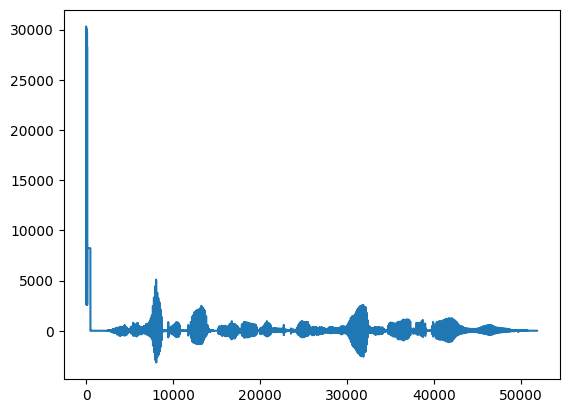

In [ ]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [ ]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1)
train_df.head()


,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihædjɹdɑɹksutinɡɹisiwɑʃwɑɾɹʔɔljiɹ,"[0, 2430, 4553, 5636, 6642, 8296, 8918, 9111, ...","[2430, 4553, 5636, 6642, 8296, 8918, 9111, 977...","[1, 2, -1, -3, -4, -3, -3, 0, -1, -1, -2, -4, ..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʌvkɔɹsdɪɹʃisɛd,"[0, 2280, 3592, 4760, 5400, 6920, 8438, 9400, ...","[2280, 3592, 4760, 5400, 6920, 8438, 9400, 110...","[0, 1, -2, -1, -2, 1, 2, 2, 0, 1, -2, 1, -2, -..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔəkɔɹɾiŋtumaɪintɹpɹiteɪʃnʌvðəpɹɑbmtulaɪnzmʌsti...,"[0, 2200, 2533, 3007, 3980, 4720, 5430, 5806, ...","[2200, 2533, 3007, 3980, 4720, 5430, 5806, 622...","[0, -2, 1, 2, -1, 0, 2, 4, 0, -1, 1, -1, 1, 1,..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃɪpɪlɾɪŋʔɪzeɪmoʊstfæsəneɪɾinpɹɑsɛs,"[0, 1960, 3843, 4840, 6520, 6920, 7686, 8689, ...","[1960, 3843, 4840, 6520, 6920, 7686, 8689, 910...","[-1, 0, 2, 2, 2, -1, -1, 2, 0, -1, -2, 0, -2, ..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",hizbɑɾipɪttʃtbæknfɔɹθʔənðəbɛnttʃ,"[0, 2040, 2494, 3190, 3950, 5240, 5420, 7680, ...","[2040, 2494, 3190, 3950, 5240, 5420, 7680, 804...","[-10, -5, 8, 7, -2, -1, 8, 16, 20, 14, 13, 15,..."


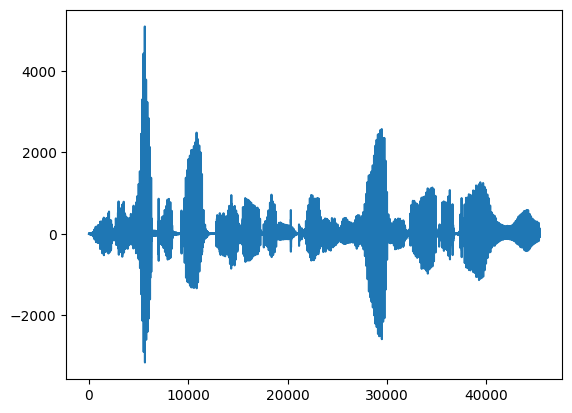

In [ ]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [ ]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

,ipa,audio
0,ʃihædjɹdɑɹksutinɡɹisiwɑʃwɑɾɹʔɔljiɹ,"[1, 2, -1, -3, -4, -3, -3, 0, -1, -1, -2, -4, ..."
1,ʌvkɔɹsdɪɹʃisɛd,"[0, 1, -2, -1, -2, 1, 2, 2, 0, 1, -2, 1, -2, -..."
2,ʔəkɔɹɾiŋtumaɪintɹpɹiteɪʃnʌvðəpɹɑbmtulaɪnzmʌsti...,"[0, -2, 1, 2, -1, 0, 2, 4, 0, -1, 1, -1, 1, 1,..."
3,ʃɪpɪlɾɪŋʔɪzeɪmoʊstfæsəneɪɾinpɹɑsɛs,"[-1, 0, 2, 2, 2, -1, -1, 2, 0, -1, -2, 0, -2, ..."
4,hizbɑɾipɪttʃtbæknfɔɹθʔənðəbɛnttʃ,"[-10, -5, 8, 7, -2, -1, 8, 16, 20, 14, 13, 15,..."


In [ ]:
train_ds = Dataset.from_pandas(train_df)

# Extend Phoneme Vocab

There may be some phonemes from TIMIT that are not accounted by the model. So we will make sure the pretrained model's tokenizer is updated for any differences

In [ ]:
timit_vocab = set("".join(train_df['ipa']))

In [ ]:
print(timit_vocab)

{'d', 'ʌ', 'ə', 'ɾ', 'n', 'ɹ', 'f', 'ʒ', 'b', 'm', 'ʃ', 'θ', 'æ', 'z', 'a', 'ɛ', 'l', 'ŋ', 's', 'ð', 'e', 'i', 'ɑ', 'ʔ', 'ɡ', 'w', 'ʊ', 't', 'v', 'k', 'h', 'o', 'u', 'ɔ', 'p', 'j', 'ɪ'}


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
# you will see how large the vocab is, we will resize our linear layer later to make it work for our smaller vocab
print(vocab)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

{'A': 113, 'C': 20, 'E': 89, 'H': 148, 'I': 124, 'O': 28, 'U': 176, 'X': 224, '[PAD]': 312, '[UNK]': 311, '_': 259, 'a': 156, 'ã': 188, 'b': 286, 'b̪': 83, 'b̪͡v': 137, 'b͡ꞵ': 80, 'c': 186, 'cʼ': 277, 'c͡ç': 265, 'd': 229, 'd̼': 210, 'd͡z': 51, 'd͡ð': 110, 'd͡ɮ': 284, 'd͡ʑ': 112, 'd͡ʒ': 214, 'e': 22, 'ẽ': 233, 'e̞': 202, 'ẽ̞': 187, 'f': 34, 'fʼ': 181, 'h': 253, 'i': 160, 'j': 92, 'k': 135, 'kxʼ': 221, 'kǀ': 25, 'kǁ': 140, 'kǂ': 115, 'kǃ': 97, 'kʘ': 165, 'kʼ': 7, 'k̚': 118, 'k͡p': 102, 'k͡x': 287, 'l': 292, 'm': 85, 'm̥': 101, 'n': 141, 'n̥': 54, 'n̼': 61, 'o': 162, 'õ': 62, 'o̞': 203, 'õ̞': 60, 'p': 38, 'pʼ': 216, 'p̚': 11, 'p̪': 236, 'p̪͡f': 205, 'p͡f': 43, 'p͡ɸ': 154, 'q': 237, 'qǀ': 9, 'qǁ': 49, 'qǂ': 196, 'qǃ': 53, 'qʘ': 119, 'qʼ': 99, 'q͡ʡ': 169, 'q͡χʼ': 44, 'q͡ꭓ': 226, 'r': 254, 'r̥': 174, 's': 201, 'sʼ': 117, 't': 39, 'tʼ': 2, 't̚': 59, 't̪͡θʼ': 50, 't̼': 307, 't͡s': 264, 't͡sʼ': 68, 't͡ɕ': 281, 't͡ɬ': 158, 't͡ɬʼ': 172, 't͡ʃ': 246, 't͡ʃʼ': 192, 't͡θ': 161, 'u': 48, 'ũ': 15

In [ ]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
tokenizer.add_tokens(list(additional_vocab))
print(additional_vocab)


set()


# Update Feature Extraction

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

## Quick Experiment

Before we fine-tune the model, lets listen to an audio clip and see how the pretrained model transcribes it. You can switch out the `model_id` for your own fine-tuned model after you complete fine-tuning!

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForCTC
from IPython.display import Audio, display
import sounddevice as sd

def predict_phonemes(audio_data, sample_rate=16000):
    """
    Predicts phoneme sequence from audio using pretrained model

    Parameters:
        audio_data: numpy array of audio samples
        sample_rate: audio sampling rate (default: 16000 Hz)
    """
    # Load model and processor
    model_id = PRE_TRAINED_ID
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForCTC.from_pretrained(model_id)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Preprocess audio
    inputs = processor(
        audio_data,
        sampling_rate=sample_rate,
        return_tensors="pt",
        padding=True
    )

    # Move inputs to same device as model
    inputs = {k: v.to(device).type(torch.float32) for k, v in inputs.items()}

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs).logits

    # Get predicted IDs and decode to phonemes
    predicted_ids = torch.argmax(outputs, dim=-1)
    predicted_transcription = processor.batch_decode(predicted_ids)

    # Clean up special tokens
    cleaned_transcription = (predicted_transcription[0]
                           .replace("<pad>", "")
                           .replace("<s>", "")
                           .replace("</s>", "")
                           .replace("<unk>", "")
                           .strip())

    return cleaned_transcription

# Example usage with your audio data
audio_sample = train_df['audio'][0]

# Play the audio
print("🔊 Playing audio sample:")
display(Audio(audio_sample, rate=16000))

# Get prediction
print("\n📝 Predicted phoneme sequence:")
phonemes = predict_phonemes(audio_sample)
print(phonemes)

🔊 Playing audio sample:



📝 Predicted phoneme sequence:


config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

ʃihædjɹ̩dɑɹksuɾɪnɡɹisiwɔʃwɔɾɹ̩ɔljɪɹ


# FINE-TUNE!


GREAT! We have cleaned up the data and have prepared our tokenizer. Now onto finetuning the model!

In [ ]:
import torch
import tempfile
from transformers import (
    AutoProcessor, AutoModelForCTC, Trainer,
    TrainingArguments, Wav2Vec2CTCTokenizer
)
from datasets import Dataset
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import logging
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.model_selection import train_test_split
import torchaudio
import json
from transformers.trainer_callback import EarlyStoppingCallback

# 🎯 Where should we save our trained model?
NEW_MODEL_ID = "./notebooks/results-b0"

# 📝 Let's set up logging so we know what's happening
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 🎵 Audio settings
SAMPLING_RATE = 16000  # 16kHz - Standard for speech processing
MAX_AUDIO_LENGTH = 160000  # 10 seconds of audio (16000 * 10)
MAX_LABEL_LENGTH = 100  # Maximum number of phonemes in a transcription

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    🧙‍♂️ The Magic Data Packer!

    This is like a helpful wizard that makes sure all our audio samples are the same length.
    Just like how you need all photos to be the same size to make a photo album,
    we need all audio clips to be the same length to train our model.

    Example:
    If we have:
        - Audio 1: [0.1, 0.2, 0.3] (3 seconds)
        - Audio 2: [0.1, 0.2] (2 seconds)

    The wizard pads Audio 2 to become:
        - Audio 2: [0.1, 0.2, 0.0] (added a 0 to make it 3 seconds)
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 📏 Find the longest audio in this batch (but not longer than our max!)
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH
        )

        # 🎵 Prepare our audio containers
        padded_inputs = []
        attention_mask = []

        # 🔄 Process each audio clip
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length

            # 🔄 Convert to tensor if it isn't already
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]

            # 1️⃣ Make sure it's a 1D array
            input_values = input_values.squeeze()

            # Pad with zeros
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))

            padded_inputs.append(padded_input)

        # 📦 Pack everything into a neat batch
        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        # 🏷️ Process the phoneme labels
        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # 🎯 Replace padding with -100 (special number that tells PyTorch to ignore these positions)
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

In [ ]:
def prepare_model_and_processor(timit_vocab):
    """

    Here we prepare our model and its vocabulary

    Example vocabulary:
    {
        "<pad>": 0,
        "<s>": 1,      # start token
        "</s>": 2,     # end token
        "æ": 4,        # The "a" in "cat"
        "t": 5,        # The "t" in "top"
        ...
    }
    """
    logger.info("Loading pretrained model and processor...")

    processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
    model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)

    # Store the old vocabulary before making any changes
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")

    # Define fixed special token IDs - pad token first for CTC
    special_tokens = {
        "<pad>": 0,  # Changed to 0 for CTC blank token
        "<s>": 1,    # Shifted up
        "</s>": 2,   # Shifted up
        "<unk>": 3   # Shifted up
    }
    logger.info("Initial special tokens setup:")
    for token, idx in special_tokens.items():
        logger.info(f"{token}: {idx}")

    # Get regular tokens (excluding special tokens)
    regular_tokens = sorted(list(timit_vocab - set(special_tokens.keys())))

    # Create combined vocabulary with fixed IDs
    vocab = {**special_tokens}  # Start with special tokens

    # Add regular tokens after special tokens
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)

    # Create tokenizer config with consistent token formats
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
    }

    # Save vocab to temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name

    # Create new tokenizer
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )

    # Verify tokenizer loaded correctly before proceeding
    loaded_vocab = new_tokenizer.get_vocab()
    logger.info("\nVerifying special token IDs in new tokenizer:")
    for token, expected_id in special_tokens.items():
        actual_id = loaded_vocab.get(token)
        logger.info(f"{token}: expected={expected_id}, actual={actual_id}")
        assert actual_id == expected_id, f"Token ID mismatch for {token}"

    # Update processor with new tokenizer
    processor.tokenizer = new_tokenizer
    os.remove(vocab_path)

    # Verify vocab size
    final_vocab_size = len(processor.tokenizer.get_vocab())
    logger.info(f"\nFinal vocabulary size: {final_vocab_size}")
    assert final_vocab_size == len(vocab), "Vocabulary size mismatch"

    # Handle model weights
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data

    # Create new layer
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    new_layer.weight.data.zero_()
    new_layer.bias.data.zero_()

    # Transfer weights and bias using the stored old_vocab
    for token, new_idx in loaded_vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]

    model.lm_head = new_layer
    model.config.vocab_size = final_vocab_size
    model.config.pad_token_id = 0  # Explicitly set pad token as CTC blank token

    # Final verification
    logger.info("\nFinal vocabulary check:")
    final_vocab = processor.tokenizer.get_vocab()
    for token, expected_id in special_tokens.items():
        actual_id = final_vocab.get(token)
        logger.info(f"{token}: {actual_id}")
        assert actual_id == expected_id, f"Final token ID mismatch for {token}"

    return model, processor

In [ ]:
def preprocess_audio(audio_input):
    """
    🎵 Audio Preprocessor

    Standardizes audio input for the model by:
    - Converting to correct format (numpy array)
    - Normalizing volume
    - Ensuring consistent length

    Parameters:
        audio_input: Can be:
            - File path (str)
            - Numpy array
            - List of values
            - PyTorch tensor

    Returns:
        np.ndarray: Processed audio as float32 numpy array
    """
    # Handle different input types
    if isinstance(audio_input, str):
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()

    elif isinstance(audio_input, (list, np.ndarray, torch.Tensor)):
        audio_numpy = np.asarray(audio_input, dtype=np.float32)
    else:
        raise ValueError(f"❌ Unsupported audio type: {type(audio_input)}")

    # Ensure we have a 1D array
    audio_numpy = audio_numpy.squeeze()

    # Normalize volume to range [-1, 1]
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()

    # Adjust length to match MAX_AUDIO_LENGTH
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        audio_numpy = np.pad(audio_numpy, (0, MAX_AUDIO_LENGTH - len(audio_numpy)))

    return audio_numpy

def prepare_datasets(train_df, processor):
    """
    🎯 Dataset Preparation

    Prepares training and evaluation datasets by:
    1. Splitting data into train/eval sets
    2. Processing audio files
    3. Converting transcriptions to token IDs

    Parameters:
        train_df: DataFrame with 'audio' and 'ipa' columns
        processor: Hugging Face processor for tokenization

    Returns:
        tuple: (training dataset, evaluation dataset)
    """
    logger.info("Splitting dataset into train and evaluation...")

    # Split data 80/20
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)

    def process_data(batch):
        """Process a single batch of data"""
        # Convert audio to standard format
        audio = preprocess_audio(batch["audio"])

        # Convert audio to model inputs
        inputs = processor(
            audio,
            sampling_rate=SAMPLING_RATE,
            return_tensors=None
        )

        # Convert IPA transcription to token IDs
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids

        return {
            "input_values": inputs["input_values"],
            "labels": labels,
            "audio": audio
        }

    # Convert to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)

    # Process datasets efficiently
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )

    return train_dataset, eval_dataset

def verify_dimensions(batch, logger):
    """
    📏 Dimension Verifier

    Helps debug tensor shapes in a batch of data.
    Prints the shape of each tensor in the batch.
    """
    logger.info("Checking batch dimensions:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            logger.info(f"{key}: {value.shape}")

def verify_token_ids(processor, stage=""):
    """
    🔍 Token ID Verifier

    Checks that special tokens and vocabulary are set up correctly.
    Useful for debugging tokenization issues.

    Parameters:
        processor: Hugging Face processor
        stage: Description of when verification is happening
    """
    logger.info(f"\n=== Token ID Verification [{stage}] ===")
    vocab = processor.tokenizer.get_vocab()
    logger.info(f"Vocabulary size: {len(vocab)}")

    # Verify special tokens
    special_tokens = ["<pad>", "<s>", "</s>", "<unk>"]
    for token in special_tokens:
        token_id = vocab.get(token)
        logger.info(f"🔑 {token}: ID {token_id}")

    # Show sample of regular tokens
    regular_tokens = [t for t in list(vocab.keys())[:5] if t not in special_tokens]
    logger.info("Sample regular tokens:")
    for token in regular_tokens:
        logger.info(f"Token {token}: ID {vocab[token]}")

    return vocab

In [ ]:
def main(train_df, timit_vocab):
    """
    🚀 Main Training Pipeline

    Coordinates the entire training process:
    1. Sets up weights & biases logging
    2. Prepares model and processor
    3. Configures training parameters
    4. Trains the model
    5. Saves the results
    """
    # Initialize weights & biases logging
    wandb.init(project="xlsr-buckeye-phoneme-prediction-overnight")

    # 🎯 Set up model and processor
    model, processor = prepare_model_and_processor(timit_vocab)

    # 🔍 Verify token setup
    vocab = verify_token_ids(processor, "After Model Preparation")
    logger.info(f"📚 Full vocabulary: {vocab}")

    # 🖥️ Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 🔧 Enable memory optimization
    model.gradient_checkpointing_enable()

    # 📊 Prepare datasets
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)

    # 🎛️ Configure training parameters
    training_args = TrainingArguments(
        output_dir="./results-b0",
        # Learning parameters
        learning_rate=8e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=4,
        max_grad_norm=0.907,

        # Optimizer settings
        adam_beta1=0.93287,
        adam_beta2=0.96748,

        # Learning rate schedule
        warmup_ratio=0.08253,
        lr_scheduler_type="cosine_with_restarts",

        # Training duration and evaluation
        num_train_epochs=40,
        logging_dir='./logs',
        logging_steps=10,
        save_steps=300,
        eval_steps=50,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,

        # Model saving settings
        save_safetensors=True,
        save_strategy="steps",
        save_total_limit=3,

        # Performance optimizations
        fp16=True,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=True,
    )

    # 📦 Set up data collator
    data_collator = DataCollatorCTCWithPadding(
        processor=processor,
        padding="longest"
    )

    # 🛑 Add early stopping
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=5,
        early_stopping_threshold=0.01
    )

    # 🎓 Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        callbacks=[early_stopping]
    )

    # 🚀 Train the model
    trainer.train("/home/arunasrivastava/ML/notebooks/results-b0/checkpoint-1800")

    # 💾 Save final model and processor
    model.save_pretrained("./results-b0")
    processor.save_pretrained("./results-b0")

    # 🔍 Final verification
    verify_token_ids(processor, "After Training")

    # ✨ Test inference
    logger.info("🎯 Testing model on a sample...")
    sample_audio = train_dataset[0]["audio"]
    inputs = processor(sample_audio, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    predicted_tokens = processor.batch_decode(predicted_ids)
    cleaned_prediction = (predicted_tokens[0]
                        .replace('<s>', '')
                        .replace('</s>', '')
                        .replace('<pad>', '')
                        .replace('<unk>', '')
                        .strip())

    logger.info(f"🎵 Raw prediction: {predicted_tokens}")
    logger.info(f"✨ Cleaned prediction: {cleaned_prediction}")

    wandb.finish()

if __name__ == "__main__":
    main(train_df, timit_vocab)

## Save Model on Hugging Face

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
from huggingface_hub import login

# Log in to Hugging Face (if not already logged in)
# login("your-huggingface-api-token")

# Load the model and processor from your local directory
model = AutoModelForCTC.from_pretrained("/home/USER/ML/notebooks/results-b0")
processor = Wav2Vec2Processor.from_pretrained("/home/USER/ML/notebooks/results-b0")

# Specify the directory where you want to save the model
save_directory = "./xlsr-timit-b0"

# Save and upload to Hugging Face Model Hub under an organization
model.save_pretrained(save_directory, push_to_hub=True, repo_id="KoelLabs/xlsr-timit-b0")
processor.save_pretrained(save_directory)


model.safetensors: 100%|██████████| 1.26G/1.26G [00:27<00:00, 45.1MB/s]


[]

# Instructions to Upload Model to Hugging Face

1. **Login to Hugging Face**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli login


2. **Create a Repository**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli repo create your-model-name --organization your-org-name

3. **Git clone**  
   Run the following command to clone your repo:
   ```bash
   git clone https://huggingface.co/your-org-name/your-model-name

4. **Upload Model**  (if you did not make it on Hugging Face already)
   Run the following command to clone your repo:
   ```bash
   huggingface-cli repo upload --path ./<path here>


5. **Move Other Files**  
   Run the following command to copy each file into the repo:
   ```bash
   cp -r ./<path here> <your-cloned-repo-folder>

6. **Stage & Commit!**
    Run the following git commands
    ```bash
    git add README.md
    git commit -m "Add model card"
    git push


### Add your fine-tuned model to the leaderboard!

#### Checkout: https://huggingface.co/spaces/KoelLabs/IPA-Transcription-EN
And get your model officially added to the board!


### YAAAAY CONGRATULATIONS

# (Optional) Hyperparam search


In [ ]:
%pip install optuna joblib
# you can use WADNB sweeps as well, whatever is easier

In [ ]:
import optuna
from transformers import TrainingArguments, EarlyStoppingCallback
from functools import partial
import wandb

def objective(trial, train_df, timit_vocab, base_output_dir="./results"):
    """
    Optuna objective function for hyperparameter optimization
    """
    # Generate a unique run name
    run_name = f"trial_{trial.number}"
    output_dir = f"{base_output_dir}/{run_name}"

    # Initialize wandb for this trial
    wandb.init(
        project="xlsr-buckeye-phoneme-prediction",
        name=run_name,
        config={"trial_number": trial.number},
        reinit=True
    )

    # Sample hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    grad_accum = trial.suggest_categorical("gradient_accumulation_steps", [2, 4, 8])
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.15)
    weight_decay = trial.suggest_float("weight_decay", 0.001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_beta1 = trial.suggest_float("adam_beta1", 0.85, 0.95)
    adam_beta2 = trial.suggest_float("adam_beta2", 0.95, 0.999)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-9, 1e-7, log=True)

    # Prepare model and data
    model, processor = prepare_model_and_processor(timit_vocab)
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)

    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()

    # Create training arguments with sampled hyperparameters
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=grad_accum,
        max_grad_norm=max_grad_norm,
        warmup_ratio=warmup_ratio,
        lr_scheduler_type="cosine",
        weight_decay=weight_decay,
        num_train_epochs=5,  # Reduced epochs for faster search
        logging_dir=f'{output_dir}/logs',
        logging_steps=50,
        save_steps=500,
        eval_steps=100,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_safetensors=True,
        save_strategy="steps",
        save_total_limit=1,  # Keep only best model
        fp16=True,
        fp16_full_eval=True,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=True,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,
    )

    # Create early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.01
    )

    # Create trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorCTCWithPadding(processor=processor, padding="longest"),
        callbacks=[early_stopping_callback]  # Add early stopping callback
    )

    # Train and get best eval loss
    try:
        train_result = trainer.train()
        eval_result = trainer.evaluate()

        # Report to wandb
        wandb.log({
            "best_eval_loss": eval_result["eval_loss"],
            "final_train_loss": train_result.training_loss,
            **{f"hp_{k}": v for k, v in trial.params.items()}
        })

        wandb.finish()

        return eval_result["eval_loss"]

    except Exception as e:
        print(f"Trial {trial.number} failed with error: {str(e)}")
        wandb.finish()
        return float('inf')

def run_hyperparameter_search(train_df, timit_vocab, n_trials=20):
    """
    Run the hyperparameter search
    """
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=1
        )
    )

    study.optimize(
        partial(objective, train_df=train_df, timit_vocab=timit_vocab),
        n_trials=n_trials,
        timeout=3600 * 12  # 12 hour timeout
    )

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

if __name__ == "__main__":
    study = run_hyperparameter_search(train_df, timit_vocab)

    # Save study results
    import joblib
    joblib.dump(study, "hyperparam_study.pkl")